<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# German News Articles - Data inspection and baseline

Reto Steiner


## Links
- [Ten Thousand German News Articles Dataset](https://tblock.github.io/10kGNAD/)

In [1]:
#%%capture

!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'
!pip install transformers
from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe
import pandas as pd
import numpy as np
import re
import tqdm
from datetime import datetime
from transformers import AutoTokenizer, TFAutoModel
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import re
tqdm.tqdm.pandas()
sns.set_style('whitegrid')

pd.options.display.max_colwidth = 600
pd.options.display.max_rows = 400


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=39d5e5751ebeb2985a37a5b0330f9642f1a48564f43ac7abccb39762573e850e
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 116.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 97.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.5 MB/s eta 0:00:00


In [2]:
file = "data/german_news_articles_original_train.parq"
download("https://drive.switch.ch/index.php/s/mRnuzx4BLpMLqyz/download", file)
data_train = load_dataframe(file)

file = "data/german_news_articles_original_test.parq"
download("https://drive.switch.ch/index.php/s/DKUnZraeGp3EIK3/download", file)
data_test = load_dataframe(file)

In [3]:
def clean_text(text, keep_punctuation=False):
    """Cleans text by removing html tags, non ascii chars, digits and optionally punctuation"""



    # Compile RE pattern for HTTPS address, then Substitute it for blank
    RE_HTTPS = re.compile(r"https?://\S+ ")
    text = re.sub(RE_HTTPS, "", text)

    # Subsitute twitter picutures for blank
    text = re.sub(r'pic.twitter.com/[\w]*',"", text)

    # Subsitute multiple points space for 1 point
    text = re.sub(r"\(?[.][.]+\)?", ".", text)

    # Compile RE pattern for HTML tags, then Substitute it for blank
    RE_TAGS = re.compile(r"<[^>]+>")
    text = re.sub(RE_TAGS, " ", text)

    # Compile RE patterns for general text, including punctuation rule
    if keep_punctuation:
        RE_ASCII = re.compile(r"[^a-züöä,.!?]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[a-züöä,.!?]\b", re.IGNORECASE)
    else:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

    # keep only ASCII + European Chars and whitespace, no digits
    text = re.sub(RE_ASCII, " ", text)
    # convert all whitespaces (tabs etc.) to single wspace
    text = re.sub(RE_SINGLECHAR, " ", text)

    # Subsitute multiple blank space for 1 blank space
    text = re.sub(r"\s+", " ", text)

    # Subsitute double punctuation (left-over after previous subsitutions) for 1 point
    text = re.sub(r" [.,]+ [,.]+", ".", text)

    return text

In [4]:
data_train["split"] = "train"
data_test["split"] = "test"
data_all = pd.concat([data_train, data_test])
data = data_train

In [5]:
data_all = data_all.drop(["text"], axis=1, errors='ignore')

# Apply text cleaning using MODIN pandas dataframe (parallelized)
data_all["text"] =  data_all["text_original"].apply(clean_text, keep_punctuation = True)

In [6]:
tokenizer = BertTokenizer.from_pretrained("Mathking/bert-base-german-cased-gnad10")
MAXLEN = 192

def tokenize(data_all):
    encoded = tokenizer.encode_plus(
        text= data_all,
        add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
        max_length=MAXLEN,  # Max length to truncate/pad
        padding='max_length',  # Pad sentence to max length
        return_attention_mask=False,  # attention mask not needed for our task
        return_token_type_ids=False,
        truncation=True, )

    return encoded['input_ids']


In [7]:
data_train = data_all[data_all['split'] == 'train'].loc[:,['text','label']]
data_test = data_all[data_all['split'] == 'test'].loc[:,['text','label']]

In [8]:
input_ids_train = np.array([tokenize(data_train) for data_train in tqdm.tqdm(data_train['text'])])
input_ids_test = np.array([tokenize(data_test) for data_test in tqdm.tqdm(data_test['text'])])

100%|██████████| 1028/1028 [00:10<00:00, 96.04it/s]


In [9]:

label_binarizer = LabelBinarizer()
label_binarizer.fit(data_all["label"])
print(f"Classes: {label_binarizer.classes_}")
print (f"Encoding:\n {label_binarizer.transform(label_binarizer.classes_).T}")

Classes: ['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']
Encoding:
 [[1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1]]


In [10]:
train_ids, test_ids, train_labels, test_labels = input_ids_train, input_ids_test, label_binarizer.transform(data_train['label']),label_binarizer.transform(data_test['label'])

In [11]:
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 1e-6
L2_reg = 1e-3
DROPOUT_RATE = 0.5

In [12]:
train_dataset = (tf.data.Dataset.from_tensor_slices((train_ids, train_labels))
                    .shuffle(buffer_size=len(train_ids), reshuffle_each_iteration=True)
                    .repeat(EPOCHS)
                    .batch(BATCH_SIZE))

test_dataset = (tf.data.Dataset.from_tensor_slices((test_ids, test_labels))
                    .batch(BATCH_SIZE))


In [13]:
NUM_CLASSES = len(pd.DataFrame(train_labels).drop_duplicates())
NUM_CLASSES

9

Loss steigt -> hohe learning rate, +/- vertauscht

Loss explodiert -> hohe lr, numerisches problem

Loss osziliert -> hohe lr, data / label fehlerhaft geladen

Loss plateau -> tiefe lr, backprob error, falscher Input in Loss

In [14]:
# Increase Model Complexity - Add more layers
def build_complex_model(max_len=MAXLEN, l2_reg1 = L2_reg, l2_reg2 = L2_reg, dropout_rate =DROPOUT_RATE):
    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_word_ids"
    )

    bert_model = TFBertModel.from_pretrained("Mathking/bert-base-german-cased-gnad10")
    encoder_outputs = bert_model(input_word_ids)

    last_hidden_state = encoder_outputs[0]
    pooler_output = encoder_outputs[1]

    cls_embedding = pooler_output

    # Add more hidden layers
    #hidden1 = tf.keras.layers.Dense(128, activation='relu')(cls_embedding)
    hidden1 = tf.keras.layers.BatchNormalization()(cls_embedding)
    hidden1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg1))(hidden1)
    hidden1 = tf.keras.layers.Dropout(rate=dropout_rate)(hidden1)
    hidden2 = tf.keras.layers.BatchNormalization()(hidden1)
    hidden2 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg2))(hidden2)
    hidden2 = tf.keras.layers.Dropout(rate=dropout_rate)(hidden2)
    # Change the output dimension to match the number of classes
    output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(hidden2)

    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)

    return model

model = build_complex_model(max_len=MAXLEN)

# Compile the model with a reduced learning rate for overfitting
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = "categorical_crossentropy"

model.compile(optimizer, loss=loss, metrics=["accuracy"], jit_compile=True)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.weight', 'classifier.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [15]:


log_dir = 'logs/' + datetime.now().strftime("%Y%m%d_%H%M%S")
# Train the model for a large number of epochs
hist = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_dataset,
    steps_per_epoch=int(np.floor((len(input_ids_train) / BATCH_SIZE))),
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="accuracy", verbose=1, patience=5, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    ],
)



Epoch 1/50
144/144 [==============================] - 400s 2s/step - loss: 2.8565 - accuracy: 0.1866 - val_loss: 1.9889 - val_accuracy: 0.5467
Epoch 2/50
144/144 [==============================] - 323s 2s/step - loss: 2.2845 - accuracy: 0.3309 - val_loss: 1.5235 - val_accuracy: 0.7714
Epoch 3/50
144/144 [==============================] - 323s 2s/step - loss: 1.9424 - accuracy: 0.4358 - val_loss: 1.2620 - val_accuracy: 0.8356
Epoch 4/50
144/144 [==============================] - 334s 2s/step - loss: 1.7189 - accuracy: 0.5277 - val_loss: 1.1203 - val_accuracy: 0.8453
Epoch 5/50
144/144 [==============================] - 322s 2s/step - loss: 1.5718 - accuracy: 0.5847 - val_loss: 1.0363 - val_accuracy: 0.8706
Epoch 6/50
144/144 [==============================] - 324s 2s/step - loss: 1.4752 - accuracy: 0.6276 - val_loss: 0.9815 - val_accuracy: 0.8881
Epoch 7/50
144/144 [==============================] - 332s 2s/step - loss: 1.3783 - accuracy: 0.6695 - val_loss: 0.9408 - val_accuracy: 0.8969

In [16]:
history = pd.DataFrame({'epoch': hist.epoch, **hist.history}).set_index('epoch')
history

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
0,2.856498,0.186632,1.988935,0.546693
1,2.284472,0.330946,1.523547,0.771401
2,1.942354,0.435764,1.262018,0.835603
3,1.718869,0.527669,1.120345,0.845331
4,1.571826,0.584744,1.036309,0.870623
5,1.475171,0.627604,0.981539,0.888132
6,1.378314,0.669488,0.940827,0.896887
7,1.323628,0.693468,0.911951,0.896887
8,1.264831,0.721788,0.886750,0.895914


<Axes: xlabel='epoch'>

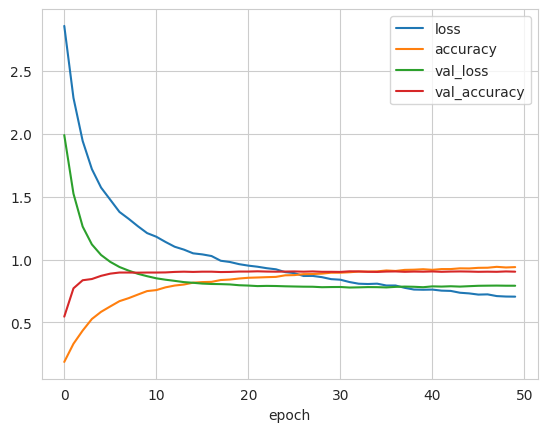

In [17]:
history.plot()

In [18]:
result = model.predict(test_ids)


33/33 [==============================] - 21s 430ms/step


In [19]:
result = result > .5
y_pred = result.astype(int)
y_true = test_labels

In [20]:
l = list(label_binarizer.classes_)

In [21]:

conf = multilabel_confusion_matrix(y_true, y_pred)

conf

array([[[955,   6],
        [ 12,  55]],

       [[912,  14],
        [ 14,  88]],

       [[865,  12],
        [ 23, 128]],

       [[969,   5],
        [  8,  46]],

       [[838,  22],
        [ 25, 143]],

       [[907,   1],
        [  2, 118]],

       [[854,   6],
        [  4, 164]],

       [[872,  15],
        [ 12, 129]],

       [[964,   7],
        [  6,  51]]])

In [22]:
"""
f1_score(y_true, y_pred, average='macro')
f1_score(y_true, y_pred, average='micro')
f1_score(y_true, y_pred, average='weighted')
"""
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score ,precision_score, make_scorer, recall_score

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred,average='macro')
roc_auc = roc_auc_score(y_true, y_pred)
prec = precision_score(y_true, y_pred,average='macro')
rec = recall_score(y_true, y_pred,average='macro')
print('Accuracy:', acc)
print('F1-Score:', f1)
print('ROC-AUC:', roc_auc)
print('Recall:', rec)
print('Precision:', prec)

Accuracy: 0.896887159533074
F1-Score: 0.8985528998401414
ROC-AUC: 0.9391978394056297
Recall: 0.8892799262583613
Precision: 0.9087493118596599


In [23]:
"""
import pickle
from google.colab import drive
drive.mount('/content/drive')

x= {'model' : model, 'result_test' : result, 'LabelBinarizer' : LabelBinarizer};
output = open('/content/drive/MyDrive/Colab Notebooks/model.pkl', 'wb')
pickle.dump(x,output)
"""

"\nimport pickle\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nx= {'model' : model, 'result_test' : result, 'LabelBinarizer' : LabelBinarizer};\noutput = open('/content/drive/MyDrive/Colab Notebooks/model.pkl', 'wb')\npickle.dump(x,output)\n"